In [ ]:
import numpy as np
import pandas as pd
from pandas.core.common import flatten
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
from sklearn import tree
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import io

from google.colab import drive
drive.mount('/content/drive')
#Reading the data using Pandas library

#df = pd.read_csv(io.StringIO(uploaded['COVID_dataset.csv'].decode('utf-8')))

Mounted at /content/drive


In [ ]:
ls

drive/  sample_data/


In [ ]:
cd "drive/My Drive/Colab Notebooks"

/content/drive/My Drive/Colab Notebooks


In [ ]:
df = pd.read_csv('COVID_dataset.csv')

In [ ]:
df.head()

,Accurate_Episode_Date,Case_Reported_Date,Test_Reported_Date,Specimen_Date,Age_Group,Client_Gender,Case_AcquisitionInfo,Reporting_PHU_City,Outbreak_Related,Reporting_PHU_Latitude,Reporting_PHU_Longitude,Outcome1
0,2020-03-30,2020-03-31,2020-03-31,2020-03-30,70s,MALE,OB,Stratford,Yes,43.368662,-81.001913,Fatal
1,2021-01-22,2021-01-24,2021-01-24,2021-01-23,50s,FEMALE,NO KNOWN EPI LINK,Newmarket,NaN,44.048023,-79.480239,Not Resolved
2,2020-03-24,2020-04-14,2020-04-14,2020-04-13,70s,FEMALE,OB,Toronto,Yes,43.656591,-79.379358,Resolved
3,2021-01-18,2021-01-21,2021-01-21,2021-01-18,<20,MALE,CC,Mississauga,NaN,43.647471,-79.708893,Not Resolved
4,2020-12-26,2020-12-28,2020-12-28,2020-12-26,60s,MALE,OB,Windsor,Yes,42.308796,-83.033670,Resolved


In [ ]:
df.info()
df.isnull().sum(axis=0)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14860 entries, 0 to 14859
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Accurate_Episode_Date    14860 non-null  object 
 1   Case_Reported_Date       14860 non-null  object 
 2   Test_Reported_Date       14657 non-null  object 
 3   Specimen_Date            14738 non-null  object 
 4   Age_Group                14855 non-null  object 
 5   Client_Gender            14860 non-null  object 
 6   Case_AcquisitionInfo     14860 non-null  object 
 7   Reporting_PHU_City       14860 non-null  object 
 8   Outbreak_Related         5778 non-null   object 
 9   Reporting_PHU_Latitude   14860 non-null  float64
 10  Reporting_PHU_Longitude  14860 non-null  float64
 11  Outcome1                 14860 non-null  object 
dtypes: float64(2), object(10)
memory usage: 1.4+ MB


Accurate_Episode_Date         0
Case_Reported_Date            0
Test_Reported_Date          203
Specimen_Date               122
Age_Group                     5
Client_Gender                 0
Case_AcquisitionInfo          0
Reporting_PHU_City            0
Outbreak_Related           9082
Reporting_PHU_Latitude        0
Reporting_PHU_Longitude       0
Outcome1                      0
dtype: int64

**Data Preprocessing**

In [ ]:
#Label (Outcome1) encoding
le = preprocessing.LabelEncoder()
#Here, we are labeling encoding the Outcome1 as Ordinal Categorical (Seriousness or severity of the outcome) data - 0 1 2
le.fit(df.Outcome1)
le.fit(['Fatal', 'Not Resolved', 'Resolved'])
le.classes_
df['Outcome1'] = le.transform(df['Outcome1'])

In [ ]:
#Here we are replacing <20 in Age_Group with 10 so that Sklearn can process it
df.loc[(df.Age_Group == '<20'),'Age_Group']='10'

#Here we are replacing the missing valves in Outbreak_Related as "No"
df['Outbreak_Related'] = df['Outbreak_Related'].fillna("No")

# Removing selected dates 
df = df.drop(['Test_Reported_Date'], axis = 1)
df = df.drop(['Specimen_Date'], axis = 1) 

#Here, we are dropping any row which has any missing values.
df = df.dropna(how='any')

#Here we are cleaning the 's' in the Age_Group so that sklearn accept the data
df = df.reset_index(drop=True)
df['Age_Group'] = df['Age_Group'].str.replace(r'\D', '')
df.isnull().sum(axis=0)


leOR = preprocessing.LabelEncoder()
leAg = preprocessing.LabelEncoder()

#Here, we are labeling encoding the Outbreak_Related as binary - 0 1
leOR.fit(df.Outbreak_Related)
leOR.fit(['Yes', 'No'])
leOR.classes_
df['Outbreak_Related'] = leOR.transform(df['Outbreak_Related'])

#Here, we are labeling encoding the Age_Group so that Sklearn treats this feature as Ordinal Categorical data
leAg.fit(df.Age_Group)
leAg.fit(['10', '20', '30', '40', '50', '60', '70', '80', '90'])
leAg.classes_
#df['Age_Group'] = leAg.transform(df['Age_Group'])

df_pp = df

#Here, we are dropping rows with GENDER DIVERSE (treating them as outliers) and UNSPECIFIED (treating them as missing values) 
df.drop(df[df['Client_Gender'] == 'GENDER DIVERSE'].index, inplace = True) 
df.drop(df[df['Client_Gender'] == 'UNSPECIFIED'].index, inplace = True) 
df = df.reset_index(drop=True)

#One-hot-encoding
enc = OneHotEncoder(handle_unknown='ignore')

en_CG = enc.fit_transform(df[['Client_Gender']]).toarray()
column_name_Gender = enc.get_feature_names(['Client_Gender'])
enc_df_Gender = pd.DataFrame(en_CG, columns= column_name_Gender)

en_CA = enc.fit_transform(df[['Case_AcquisitionInfo']]).toarray()
column_name_CA = enc.get_feature_names(['Case_AcquisitionInfo'])
enc_df_CA = pd.DataFrame(en_CA, columns= column_name_CA)

df = df.join(enc_df_Gender)
df = df.join(enc_df_CA)

#en_City = enc.fit_transform(df[['Reporting_PHU_City']]).toarray()
#column_name_City = enc.get_feature_names(['Reporting_PHU_City'])
#enc_df_City = pd.DataFrame(en_City, columns= column_name_City)

#df = df.join(enc_df_City)

#####################################################################
#df = df.drop(['Outbreak_Related'], axis = 1) 
#df = df.drop(['Reporting_PHU_Latitude'], axis = 1) 
#df = df.drop(['Reporting_PHU_Longitude'], axis = 1) 

df = df.drop(['Client_Gender'], axis = 1) 
df = df.drop(['Case_AcquisitionInfo'], axis = 1) 
df = df.drop(['Reporting_PHU_City'], axis = 1) 

from datetime import date

for i in range(len(df['Accurate_Episode_Date'])):
  df['Accurate_Episode_Date'][i] = (date.fromisoformat(df['Accurate_Episode_Date'][i]) - date(2018, 1, 1)).days
  df['Case_Reported_Date'][i] = (date.fromisoformat(df['Case_Reported_Date'][i]) - date(2018, 1, 1)).days

df_OC = df['Outcome1']
df = df.drop(['Outcome1'], axis = 1) 
dfX = df
df = df.join(df_OC)

#X = df_pp.iloc[:,:-1].values
#y = df_pp.iloc[:,7].values
X = df.iloc[:,:-1].values.astype(float)
y = df.iloc[:,14].values.astype(int)


print(df.shape)
df.head()



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


(14751, 15)


,Accurate_Episode_Date,Case_Reported_Date,Age_Group,Outbreak_Related,Reporting_PHU_Latitude,Reporting_PHU_Longitude,Client_Gender_FEMALE,Client_Gender_MALE,Case_AcquisitionInfo_CC,Case_AcquisitionInfo_MISSING INFORMATION,Case_AcquisitionInfo_NO KNOWN EPI LINK,Case_AcquisitionInfo_OB,Case_AcquisitionInfo_TRAVEL,Case_AcquisitionInfo_UNSPECIFIED EPI LINK,Outcome1
0,819,820,70,1,43.368662,-81.001913,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0
1,1117,1119,50,0,44.048023,-79.480239,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1
2,813,834,70,1,43.656591,-79.379358,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2
3,1113,1116,10,0,43.647471,-79.708893,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1
4,1090,1092,60,1,42.308796,-83.033670,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,2


In [ ]:
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()

# X  = sc_X.fit_transform(X)
# # y  = sc_X.fit_transform(y.reshape(-1, 1))

X[:,[4,5]]  = sc_X.fit_transform(X[:,[4,5]])
X[:,[0,1,2]]  = sc_X.fit_transform(X[:,[0,1,2]])


#Split arrays or matrices into random train and test subsets
X_train, X_validate, y_train, y_validate = train_test_split(X, y, test_size=0.40, random_state = 275)
X_test, X_validate, y_test, y_validate = train_test_split(X, y, test_size=0.50, random_state = 275)

In [ ]:
# MLP with automatic validation set
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.optimizers import SGD

from sklearn.metrics import classification_report, confusion_matrix
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout

from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline


In [ ]:
#y_train = keras.utils.to_categorical(y_train, num_classes = 3)
#y_test = keras.utils.to_categorical(y_test, num_classes = 3)
#print(y_train.shape)

(11720, 3)


In [ ]:
model_a = Sequential()
# model.add(Dense(100, activation='relu', input_dim=18))
# model.add(Dense(3, activation='softmax'))
# model_a.add(Dense(100, activation='relu', input_dim=(18)))
# model_a.add(Dense(200, activation='relu'))
# model_a.add(Dense(200, activation='relu'))
# model_a.add(Dense(3))
# #sgd = SGD(lr = 0.01, decay = 1e-6, momentum = 0.9, nesterov=True)
# model_a.compile(optimizer='adam',
#               loss='sparse_categorical_crossentropy',
#               metrics=['accuracy'])

model_a = Sequential()
model_a.add(Dense(100, activation='relu', input_dim=14))
model_a.add(Dense(500,activation='relu'))
model_a.add(Dense(300,activation='relu'))
model_a.add(Dropout(0.2))
model_a.add(Dense(3,activation='softmax'))
model_a.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
#sgd = SGD(lr = 0.01, decay = 1e-6, momentum = 0.9, nesterov=True)
model_a.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
start_train_time = time.time()

history = model_a.fit(X_train, y_train, epochs = 30, batch_size = 5, validation_data=(X_validate, y_validate))

print("--- %s seconds ---" % (time.time() - start_train_time))

Epoch 1/30
1770/1770 [==============================] - 8s 4ms/step - loss: 0.4650 - accuracy: 0.8141 - val_loss: 0.3078 - val_accuracy: 0.8839
Epoch 2/30
1770/1770 [==============================] - 8s 4ms/step - loss: 0.3011 - accuracy: 0.8895 - val_loss: 0.2781 - val_accuracy: 0.8995
Epoch 3/30
1770/1770 [==============================] - 7s 4ms/step - loss: 0.2920 - accuracy: 0.8881 - val_loss: 0.2826 - val_accuracy: 0.9008
Epoch 4/30
1770/1770 [==============================] - 7s 4ms/step - loss: 0.2737 - accuracy: 0.8993 - val_loss: 0.2586 - val_accuracy: 0.9090
Epoch 5/30
1770/1770 [==============================] - 7s 4ms/step - loss: 0.2646 - accuracy: 0.9021 - val_loss: 0.2679 - val_accuracy: 0.8975
Epoch 6/30
1770/1770 [==============================] - 7s 4ms/step - loss: 0.2621 - accuracy: 0.9045 - val_loss: 0.2888 - val_accuracy: 0.8976
Epoch 7/30
1770/1770 [==============================] - 7s 4ms/step - loss: 0.2624 - accuracy: 0.9073 - val_loss: 0.2936 - val_accuracy:

In [ ]:
import time

start_train_time = time.time()

score = model_a.evaluate(X_test, y_test, verbose = 0)

print("--- %s seconds ---" % (time.time() - start_train_time))

--- 0.3494298458099365 seconds ---


Test score: 0.22184570133686066
Test accuracy: 0.9126779437065125


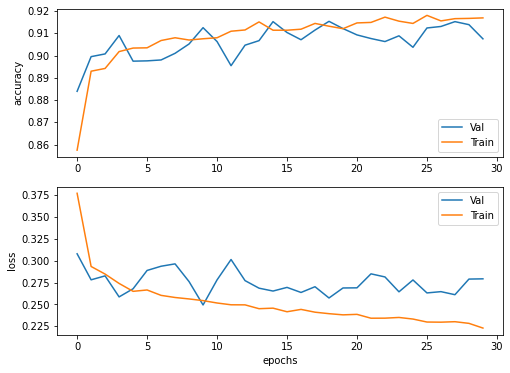

In [ ]:
print('Test score:', score[0])
print('Test accuracy:', score[1])

fig, (ax1, ax2) = plt.subplots(2, figsize=(8, 6))

history1 = history
acc = history1.history['accuracy']
loss = history1.history['loss']
val_acc = history1.history['val_accuracy']
val_loss = history1.history['val_loss']
ax1.plot(val_acc, label='Val')
ax1.plot(acc, label='Train')
ax2.plot(val_loss, label='Val')
ax2.plot(loss, label='Train')
    
ax1.set_ylabel('accuracy')
ax2.set_ylabel('loss')
ax2.set_xlabel('epochs')
ax1.legend()
ax2.legend()
plt.show()

In [ ]:
df = pd.read_csv('COVID_dataset_test.csv')


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3704 entries, 0 to 3703
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       3704 non-null   int64  
 1   Accurate_Episode_Date    3704 non-null   object 
 2   Case_Reported_Date       3704 non-null   object 
 3   Test_Reported_Date       3654 non-null   object 
 4   Specimen_Date            3674 non-null   object 
 5   Age_Group                3704 non-null   object 
 6   Client_Gender            3704 non-null   object 
 7   Case_AcquisitionInfo     3704 non-null   object 
 8   Reporting_PHU_City       3704 non-null   object 
 9   Outbreak_Related         1488 non-null   object 
 10  Reporting_PHU_Latitude   3704 non-null   float64
 11  Reporting_PHU_Longitude  3704 non-null   float64
dtypes: float64(2), int64(1), object(9)
memory usage: 347.4+ KB


In [ ]:
df.isnull().sum(axis=0)


id                            0
Accurate_Episode_Date         0
Case_Reported_Date            0
Test_Reported_Date           50
Specimen_Date                30
Age_Group                     0
Client_Gender                 0
Case_AcquisitionInfo          0
Reporting_PHU_City            0
Outbreak_Related           2216
Reporting_PHU_Latitude        0
Reporting_PHU_Longitude       0
dtype: int64

In [ ]:
#This is for Kaggle
df = pd.read_csv('COVID_dataset_test.csv')
print(df.head())

#Here we are replacing <20 in Age_Group with 10 so that Sklearn can process it
df.loc[(df.Age_Group == '<20'),'Age_Group']='10'

#Here we are replacing the missing valves in Outbreak_Related as "No"
df['Outbreak_Related'] = df['Outbreak_Related'].fillna("No")

df = df.drop(['Test_Reported_Date'], axis = 1)
df = df.drop(['Specimen_Date'], axis = 1) 

#df['Test_Reported_Date'] = df['Test_Reported_Date'].fillna('4/14/2020')
#df['Specimen_Date'] = df['Specimen_Date'].fillna('4/14/2020')

#Here, we are dropping any row which has any missing values.
#df = df.dropna(how='any')

df.isnull().sum(axis=0)

#Here we are cleaning the 's' in the Age_Group so that sklearn accept the data
df = df.reset_index(drop=True)
df['Age_Group'] = df['Age_Group'].str.replace(r'\D', '')
df.isnull().sum(axis=0)


leOR = preprocessing.LabelEncoder()
leAg = preprocessing.LabelEncoder()

#Here, we are labeling encoding the Outbreak_Related as binary - 0 1
leOR.fit(df.Outbreak_Related)
leOR.fit(['Yes', 'No'])
leOR.classes_
df['Outbreak_Related'] = leOR.transform(df['Outbreak_Related'])

#Here, we are labeling encoding the Age_Group so that Sklearn treats this feature as Ordinal Categorical data
leAg.fit(df.Age_Group)
leAg.fit(['10', '20', '30', '40', '50', '60', '70', '80', '90'])
leAg.classes_
df['Age_Group'] = leAg.transform(df['Age_Group'])

df_pp = df

#One-hot-encoding
enc = OneHotEncoder(handle_unknown='ignore')

en_CG = enc.fit_transform(df[['Client_Gender']]).toarray()
column_name_Gender = enc.get_feature_names(['Client_Gender'])
enc_df_Gender = pd.DataFrame(en_CG, columns= column_name_Gender)

en_CA = enc.fit_transform(df[['Case_AcquisitionInfo']]).toarray()
column_name_CA = enc.get_feature_names(['Case_AcquisitionInfo'])
enc_df_CA = pd.DataFrame(en_CA, columns= column_name_CA)

df = df.join(enc_df_Gender)
df = df.join(enc_df_CA)

#en_City = enc.fit_transform(df[['Reporting_PHU_City']]).toarray()
#column_name_City = enc.get_feature_names(['Reporting_PHU_City'])
#enc_df_City = pd.DataFrame(en_City, columns= column_name_City)

#df = df.join(enc_df_City)

#####################################################################
#df = df.drop(['Outbreak_Related'], axis = 1) 
#df = df.drop(['Reporting_PHU_Latitude'], axis = 1) 
#df = df.drop(['Reporting_PHU_Longitude'], axis = 1) 

df = df.drop(['Client_Gender'], axis = 1) 
df = df.drop(['Case_AcquisitionInfo'], axis = 1) 
df = df.drop(['Reporting_PHU_City'], axis = 1) 
df = df.drop(['Client_Gender_UNSPECIFIED'], axis = 1) 

from datetime import date

for i in range(len(df['Accurate_Episode_Date'])):
  df['Accurate_Episode_Date'][i] = (date.fromisoformat(df['Accurate_Episode_Date'][i]) - date(2018, 1, 1)).days
  df['Case_Reported_Date'][i] = (date.fromisoformat(df['Case_Reported_Date'][i]) - date(2018, 1, 1)).days
  #df['Test_Reported_Date'][i] = (date.fromisoformat(df['Test_Reported_Date'][i]) - date(2018, 1, 1)).days
  #df['Specimen_Date'][i] = (date.fromisoformat(df['Specimen_Date'][i]) - date(2018, 1, 1)).days

df_ID = df['id']
df = df.drop(['id'], axis = 1) 

X_FT = df.iloc[:,:].values.astype(float)

X_FT[:,[4,5]]  = sc_X.fit_transform(X_FT[:,[4,5]])
X_FT[:,[0,1]]  = sc_X.fit_transform(X_FT[:,[0,1]])

y_pred_k = model_a.predict_classes(X_FT)
print(y_pred_k)

print(df.shape)
df.head()


   id Accurate_Episode_Date  ... Reporting_PHU_Latitude Reporting_PHU_Longitude
0   0            2020-07-03  ...              43.647471              -79.708893
1   1            2021-01-05  ...              44.301632              -78.321347
2   2            2021-01-02  ...              43.656591              -79.379358
3   3            2020-12-04  ...              43.257631              -79.871341
4   4            2021-01-17  ...              43.656591              -79.379358

[5 rows x 12 columns]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


[0 0 0 ... 0 0 0]
(3704, 14)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


,Accurate_Episode_Date,Case_Reported_Date,Age_Group,Outbreak_Related,Reporting_PHU_Latitude,Reporting_PHU_Longitude,Client_Gender_FEMALE,Client_Gender_MALE,Case_AcquisitionInfo_CC,Case_AcquisitionInfo_MISSING INFORMATION,Case_AcquisitionInfo_NO KNOWN EPI LINK,Case_AcquisitionInfo_OB,Case_AcquisitionInfo_TRAVEL,Case_AcquisitionInfo_UNSPECIFIED EPI LINK
0,914,917,2,0,43.647471,-79.708893,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
1,1100,1108,7,0,44.301632,-78.321347,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,1097,1102,5,0,43.656591,-79.379358,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
3,1068,1069,6,1,43.257631,-79.871341,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,1112,1114,3,0,43.656591,-79.379358,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0


In [ ]:
y_tar = le.inverse_transform(y_pred_k)
print(y_tar)
print(y_tar.shape)

my_submission = pd.DataFrame({'id': df_ID, 'Outcome1': y_tar})
my_submission.to_csv('A4submission_covid-2.csv', index=False)

['Fatal' 'Fatal' 'Fatal' ... 'Fatal' 'Fatal' 'Fatal']
(3704,)


**Model B**

In [ ]:
model_b = Sequential()
model_b.add(Dense(200, activation='relu', input_dim=18))
model_b.add(Dense(3, activation='softmax'))
#sgd = SGD(lr = 0.01, decay = 1e-6, momentum = 0.9, nesterov=True)
model_b.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])



In [ ]:
start_train_time = time.time()

history_b = model_b.fit(X_train, y_train, epochs = 30, batch_size = 5, validation_data=(X_validate, y_validate))

print("--- %s seconds ---" % (time.time() - start_train_time))

score_b = model_b.evaluate(X_test, y_test, verbose = 0)


Epoch 1/30
1758/1758 [==============================] - 4s 2ms/step - loss: 0.5466 - accuracy: 0.7803 - val_loss: 0.5166 - val_accuracy: 0.8139
Epoch 2/30
1758/1758 [==============================] - 4s 2ms/step - loss: 0.3978 - accuracy: 0.8521 - val_loss: 0.4308 - val_accuracy: 0.8214
Epoch 3/30
1758/1758 [==============================] - 4s 2ms/step - loss: 0.3651 - accuracy: 0.8671 - val_loss: 0.5465 - val_accuracy: 0.8321
Epoch 4/30
1758/1758 [==============================] - 4s 2ms/step - loss: 0.3511 - accuracy: 0.8751 - val_loss: 0.2965 - val_accuracy: 0.8957
Epoch 5/30
1758/1758 [==============================] - 4s 2ms/step - loss: 0.3262 - accuracy: 0.8816 - val_loss: 0.3187 - val_accuracy: 0.8788
Epoch 6/30
1758/1758 [==============================] - 4s 2ms/step - loss: 0.3172 - accuracy: 0.8885 - val_loss: 0.3138 - val_accuracy: 0.8947
Epoch 7/30
1758/1758 [==============================] - 4s 2ms/step - loss: 0.3172 - accuracy: 0.8871 - val_loss: 0.2885 - val_accuracy:

Test score: 0.2510411739349365
Test accuracy: 0.9104436635971069


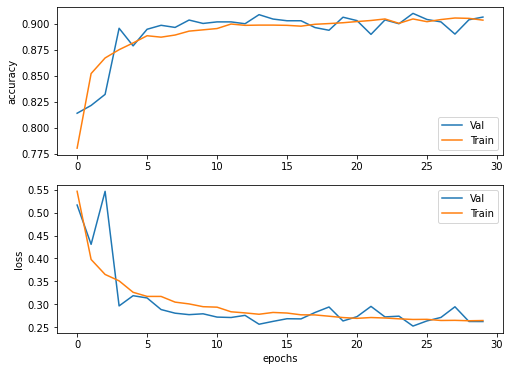

In [ ]:
print('Test score:', score_b[0])
print('Test accuracy:', score_b[1])

fig, (ax1, ax2) = plt.subplots(2, figsize=(8, 6))

acc = history_b.history['accuracy']
loss = history_b.history['loss']
val_acc = history_b.history['val_accuracy']
val_loss = history_b.history['val_loss']
ax1.plot(val_acc, label='Val')
ax1.plot(acc, label='Train')
ax2.plot(val_loss, label='Val')
ax2.plot(loss, label='Train')
    
ax1.set_ylabel('accuracy')
ax2.set_ylabel('loss')
ax2.set_xlabel('epochs')
ax1.legend()
ax2.legend()
plt.show()